# Building Neural Network Pipeline for problem from scratch

Using the neural network structure here: https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models

and applying to our problem

#### Dependencies

In [223]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dense, Concatenate, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline
import gensim
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 1

import sys
sys.path.append('../src')

from datatasks.sample_data import sample_data

from datatasks.new_preprocess import tokenize

from models.models import evaluate_model

from models.plot import plot_confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data

In [2]:
DATA_PATH = '../data/'
DATA_INTERIM_PATH = DATA_PATH + 'interim/'
train = pd.read_csv(DATA_INTERIM_PATH + 'train_p.csv')
val = pd.read_csv(DATA_INTERIM_PATH + 'val_p.csv')

#### Sample data

In [3]:
train_s = sample_data(train, 50000, 'train')
val_s = sample_data(val, 10000, 'val')

In [4]:
train_s.head(2)

,index,id,published-at,title,article_text,external_links,internal_links,hyperpartisan,bias,url,labeled-by,HP_links_count,nonHP_links_count,unknown_links_count,domain,preprocessed_text
0,189698,376419,2009-07-20,?Brown Bailout?? Hardly,"Last month, FedEx launched a multimillion-doll...",{'http://www.reuters.com/article/companyNews/i...,{},False,least,https://factcheck.org/2009/07/brown-bailout-ha...,publisher,0,4,6,factcheck,"Brown Bailout Hardly\n Last month, FedEx launc..."
1,120949,233372,2015-08-25,Prosecutors: Ex-surgeon calls himself 'killer'...,DALLAS (AP) ? A Texas neurosurgeon facing crim...,{},{},False,least,https://apnews.com/amp/123a956665774b639465eec...,publisher,0,0,0,apnews,Prosecutors: Ex-surgeon calls himself killer i...


#### Tokenize

In [5]:
train_s = tokenize(train_s)

#### Embed text

In [6]:
word2vec_path = "../data/external/GoogleNews-vectors-negative300.bin.gz"
#vectors = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [232]:
MAX_SEQUENCE_LENGTH = 35
EMBEDDING_DIM = 300
VALIDATION_SPLIT=.2

In [233]:
def create_cnn_data(df, vectors):
    
    all_words = [word for tokens in df["tokens"] for word in tokens]
    VOCAB = sorted(list(set(all_words)))
    VOCAB_SIZE = len(VOCAB)

    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(df["preprocessed_text"].tolist())
    sequences = tokenizer.texts_to_sequences(df["preprocessed_text"].tolist())

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    labels = np.asarray(df["hyperpartisan"])

    indices = np.arange(cnn_data.shape[0])
    np.random.shuffle(indices)
    cnn_data = cnn_data[indices]
    labels = labels[indices]
    num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

    embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
    for word,index in word_index.items():
        embedding_weights[index,:] = vectors[word] if word in vectors else np.random.rand(EMBEDDING_DIM)
    print(embedding_weights.shape)
    
    return cnn_data, labels, embedding_weights, word_index, num_validation_samples

In [234]:
cnn_data, labels, embedding_weights, word_index, num_validation_samples = create_cnn_data(train_s, vectors)

Found 275014 unique tokens.
(275015, 300)


#### Custom features matrix

In [235]:
custom_features_train = train_s[['HP_links_count']].values
custom_features_val = val_s[['HP_links_count']].values

#### Create NN function

In [236]:
def create_nn_model(embeddings, max_sequence_length, num_words, embedding_dim, custom_features, trainable=False):
    
    # Main input layer for text features
    main_input = Input(shape=(max_sequence_length,), dtype='int32', name='main_input')
    
    # Create embeddings
    x = Embedding(input_dim=num_words,
                 output_dim=embedding_dim,
                 weights=[embeddings],
                 input_length=max_sequence_length,
                 trainable=trainable)(main_input)
    
    x = SpatialDropout1D(0.2)(x)
    
    # Layers for text only features
    #lstm_out = Bidirectional(LSTM(32, dropout=0.2))(x)
    
    #print(lstm_out.shape)
    
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(x)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)
    
    conv_out = Dropout(0.5)(l_merge)
    conv_out = Flatten()(conv_out)
    
    # Aux output for text features only
    auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(conv_out)
    
    # Input layer for custom features
    auxiliary_input = Input(shape=(custom_features.shape[1],), name='aux_input')
    
    # Concatenate text and custom features
    x = keras.layers.concatenate([conv_out, auxiliary_input])
    
    # Dense layers using text and custom features
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    # And finally we add the main logistic regression layer
    main_output = Dense(1, activation='sigmoid', name='main_output')(x)
    
    # Create and compile model
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])
    model.compile(optimizer='adam', loss='binary_crossentropy', loss_weights=[1., 0.2], metrics=['accuracy'])
    
    return model

#### Wrap model for pipeline

In [237]:
model = create_nn_model(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, custom_features_train, False)

In [238]:
x_train = cnn_data
x_custom_train = custom_features_train
y_train = labels

In [ ]:
model.fit([x_train, x_custom_train], [y_train, y_train], validation_data=([t_cnn_data, custom_features_val], [t_labels, t_labels]), epochs=30, batch_size=128, verbose=1)

Train on 49997 samples, validate on 9999 samples
Epoch 1/30
49997/49997 [==============================] - 45s 902us/step - loss: 0.7828 - main_output_loss: 0.6633 - aux_output_loss: 0.5972 - main_output_acc: 0.5659 - aux_output_acc: 0.6533 - val_loss: 0.8517 - val_main_output_loss: 0.7023 - val_aux_output_loss: 0.7469 - val_main_output_acc: 0.4907 - val_aux_output_acc: 0.4918
Epoch 2/30
49997/49997 [==============================] - 45s 898us/step - loss: 0.6639 - main_output_loss: 0.5638 - aux_output_loss: 0.5004 - main_output_acc: 0.7077 - aux_output_acc: 0.7398 - val_loss: 0.8983 - val_main_output_loss: 0.7499 - val_aux_output_loss: 0.7418 - val_main_output_acc: 0.4776 - val_aux_output_acc: 0.5270
Epoch 3/30
49997/49997 [==============================] - 45s 900us/step - loss: 0.6032 - main_output_loss: 0.5105 - aux_output_loss: 0.4634 - main_output_acc: 0.7488 - aux_output_acc: 0.7664 - val_loss: 0.9089 - val_main_output_loss: 0.7587 - val_aux_output_loss: 0.7513 - val_main_output

In [ ]:
val_s = tokenize(val_s)

In [239]:
t_cnn_data, t_labels, t_embedding_weights, t_word_index, t_num_validation_samples = create_cnn_data(val_s, vectors)

Found 129553 unique tokens.
(129554, 300)


In [200]:
preds = model.predict([t_cnn_data, custom_features_val])

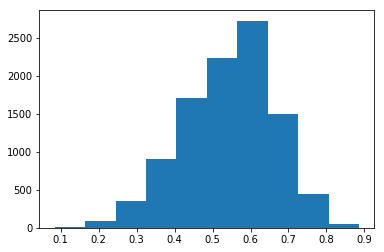

In [201]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.hist(preds[1])

In [202]:
preds = [0 if preds[0][i][0] < .5 else 1 for i in range(len(preds[1]))]

In [203]:
evaluate_model(preds, t_labels)

             precision    recall  f1-score   support

      False       0.52      0.32      0.40      4999
       True       0.51      0.70      0.59      5000

avg / total       0.52      0.51      0.50      9999

Accuracy: 0.5136


0.5135513551355135